## Graph Transformers for Blood-Brain-Barrier Penetration Prediction
**Ayush Noori**

First, I load the relevant libraries.

In [1]:
# import base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # inline plots
from matplotlib import colors # colors for histogram
%matplotlib inline

# TDC library
from tdc.benchmark_group import admet_group
from tdc.chem_utils import MolConvert

# XGBoost
import xgboost as xgb

# import Optuna
import optuna
from optuna.samplers import TPESampler
import optuna.visualization.matplotlib as oviz

# logging to show Optuna output
import logging
import sys

# metrics for ROC/AUC
from sklearn import metrics

# time management
from datetime import datetime

# create time object used for file names
my_time = datetime.now()

In [2]:
group = admet_group(path = 'data/')
predictions_list = []

Found local copy...


Next, I retrieve the data.

In [3]:
# set seed and benchmark in benchmark group
seed = 1
benchmark = group.get('BBB_Martins') 
    
# all benchmark names in a benchmark group are stored in group.dataset_names
predictions = {}
name = benchmark['name']
train_val, test = benchmark['train_val'], benchmark['test']
# train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

I define the XGBoost training function. First, I convert the SMILES structures to fingerprints. Note that conversion from `SMILES` to `RDKit2D` requires `pip install git+https://github.com/bp-kelley/descriptastorus` and `pip install pandas-flavor`.

The parameter definition code was inspired by [this Medium post](https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407) with [this source code](https://gist.github.com/Crissman/4ddeec6718627ecef46f863e1bf90424#file-xgboost_integration-py). See [the documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) for a full list of possible parameters.

In [7]:
# define training function
def train_xgboost(trial):

    # define fingerprint
    mol_dst = trial.suggest_categorical("mol_dst", ["ECFP2", "ECFP4", "MACCS", "Morgan", "Daylight", "RDKit2D"])

    # define the XGBoost parameters, inspired by 
    params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        }

    if params["booster"] == "gbtree" or params["booster"] == "dart":
        params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        params["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        params["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # print all of the hyperparameters of the training iteration:
    print("\n===== TRIAL #{} =====".format(trial.number))
    print("Fingerprint: {}".format(mol_dst))
    print("Booster: {}".format(params["booster"]))
    print("Lambda: {}".format(params["lambda"]))
    print("Alpha: {}".format(params["alpha"]))

    # convert fingerprint
    converter = MolConvert(src = 'SMILES', dst = mol_dst)
    train_val_features = pd.DataFrame([converter(x) for x in train_val['Drug']])

    # define the optimized DMatrix object
    dtrain_val = xgb.DMatrix(train_val_features, label = train_val['Y'])

    # perform cross-validation
    cv_results = xgb.cv(dtrain = dtrain_val, params = params, nfold = 5, \
        num_boost_round = 100, early_stopping_rounds = 10, metrics = "auc", as_pandas = True, seed = seed)

    # train final model based on parameters in Optuna trial
    xgb_model = xgb.train(dtrain = dtrain_val, params = params, num_boost_round = 50)

    # report the final boosting metric as the summary metric for this Optuna trial
    test_auc_mean = cv_results["test-auc-mean"].tail(1)

    # return model and metric
    return xgb_model, test_auc_mean

I define the Optuna objective function.

In [8]:
# define directories
optuna_dir = "optuna/"
model_dir = optuna_dir + "models/"
study_dir = optuna_dir + "database/"

# define objective function
def objective(trial):

    # start the training loop
    trial_xgb_model, trial_test_auc_mean = train_xgboost(trial)

    # save model for this loop
    trial_xgb_model.save_model(model_dir + "xgboost_model_{}.json".format(trial.number))

    return trial_test_auc_mean

I run the Optuna trials.

In [9]:
# add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# create study
study_name = "xgboost-study"  # unique identifier of the study
storage_name = "sqlite:///{}.db".format(study_dir + study_name)
study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed = 1234, multivariate = True), study_name = study_name, storage = storage_name, load_if_exists = False)

# optimize hyperparameters
study.optimize(objective, n_trials = 20, gc_after_trial = True)

[I 2022-05-04 15:39:59,612] A new study created in RDB with name: xgboost-study


A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study

===== TRIAL #0 =====
Fingerprint: Morgan
Booster: dart
Lambda: 0.10173281877564906
Alpha: 7.286821979964728e-06


[I 2022-05-04 15:43:54,006] Trial 0 finished with value: 0.8097418106377839 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.10173281877564906, 'alpha': 7.286821979964728e-06, 'max_depth': 5, 'eta': 0.0029356446287146696, 'gamma': 0.005030558640374879, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.300186889879715e-06, 'skip_drop': 0.0008378560837656436}. Best is trial 0 with value: 0.8097418106377839.


Trial 0 finished with value: 0.8097418106377839 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.10173281877564906, 'alpha': 7.286821979964728e-06, 'max_depth': 5, 'eta': 0.0029356446287146696, 'gamma': 0.005030558640374879, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.300186889879715e-06, 'skip_drop': 0.0008378560837656436}. Best is trial 0 with value: 0.8097418106377839.
Trial 0 finished with value: 0.8097418106377839 and parameters: {'mol_dst': 'Morgan', 'booster': 'dart', 'lambda': 0.10173281877564906, 'alpha': 7.286821979964728e-06, 'max_depth': 5, 'eta': 0.0029356446287146696, 'gamma': 0.005030558640374879, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.300186889879715e-06, 'skip_drop': 0.0008378560837656436}. Best is trial 0 with value: 0.8097418106377839.

===== TRIAL #1 =====
Fingerprint: MACCS
Booster: dart
Lambda: 3.08593938432114e-05
Alpha: 0.02613251068

[I 2022-05-04 15:44:08,643] Trial 1 finished with value: 0.8115841090355446 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 3.08593938432114e-05, 'alpha': 0.026132510685001994, 'max_depth': 2, 'eta': 0.004306136267611569, 'gamma': 0.004331621149409642, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.392446475585359e-08, 'skip_drop': 0.0025063836490049306}. Best is trial 1 with value: 0.8115841090355446.


Trial 1 finished with value: 0.8115841090355446 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 3.08593938432114e-05, 'alpha': 0.026132510685001994, 'max_depth': 2, 'eta': 0.004306136267611569, 'gamma': 0.004331621149409642, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.392446475585359e-08, 'skip_drop': 0.0025063836490049306}. Best is trial 1 with value: 0.8115841090355446.
Trial 1 finished with value: 0.8115841090355446 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 3.08593938432114e-05, 'alpha': 0.026132510685001994, 'max_depth': 2, 'eta': 0.004306136267611569, 'gamma': 0.004331621149409642, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.392446475585359e-08, 'skip_drop': 0.0025063836490049306}. Best is trial 1 with value: 0.8115841090355446.

===== TRIAL #2 =====
Fingerprint: ECFP2
Booster: gblinear
Lambda: 1.132693728513012e-08
Alpha: 0.00087002

[I 2022-05-04 15:44:22,530] Trial 2 finished with value: 0.8968279067428011 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gblinear', 'lambda': 1.132693728513012e-08, 'alpha': 0.0008700288829548732}. Best is trial 2 with value: 0.8968279067428011.


Trial 2 finished with value: 0.8968279067428011 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gblinear', 'lambda': 1.132693728513012e-08, 'alpha': 0.0008700288829548732}. Best is trial 2 with value: 0.8968279067428011.
Trial 2 finished with value: 0.8968279067428011 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gblinear', 'lambda': 1.132693728513012e-08, 'alpha': 0.0008700288829548732}. Best is trial 2 with value: 0.8968279067428011.

===== TRIAL #3 =====
Fingerprint: MACCS
Booster: gbtree
Lambda: 1.1442992577958549e-05
Alpha: 2.6976740926344954e-08


[I 2022-05-04 15:44:37,422] Trial 3 finished with value: 0.9003341513917519 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 1.1442992577958549e-05, 'alpha': 2.6976740926344954e-08, 'max_depth': 5, 'eta': 0.7178569876429466, 'gamma': 9.807122586338795e-08, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.


Trial 3 finished with value: 0.9003341513917519 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 1.1442992577958549e-05, 'alpha': 2.6976740926344954e-08, 'max_depth': 5, 'eta': 0.7178569876429466, 'gamma': 9.807122586338795e-08, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.
Trial 3 finished with value: 0.9003341513917519 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 1.1442992577958549e-05, 'alpha': 2.6976740926344954e-08, 'max_depth': 5, 'eta': 0.7178569876429466, 'gamma': 9.807122586338795e-08, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.

===== TRIAL #4 =====
Fingerprint: Daylight
Booster: gbtree
Lambda: 3.1271259781156594e-05
Alpha: 0.0007892089042326942


[I 2022-05-04 15:45:05,932] Trial 4 finished with value: 0.821840134837957 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 3.1271259781156594e-05, 'alpha': 0.0007892089042326942, 'max_depth': 9, 'eta': 0.0010136624520181068, 'gamma': 0.004446113249362318, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.


Trial 4 finished with value: 0.821840134837957 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 3.1271259781156594e-05, 'alpha': 0.0007892089042326942, 'max_depth': 9, 'eta': 0.0010136624520181068, 'gamma': 0.004446113249362318, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.
Trial 4 finished with value: 0.821840134837957 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 3.1271259781156594e-05, 'alpha': 0.0007892089042326942, 'max_depth': 9, 'eta': 0.0010136624520181068, 'gamma': 0.004446113249362318, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.

===== TRIAL #5 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 0.00019725387492289337
Alpha: 0.03577803927837878


[I 2022-05-04 15:45:17,419] Trial 5 finished with value: 0.6438324576215255 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.00019725387492289337, 'alpha': 0.03577803927837878, 'max_depth': 1, 'eta': 0.0022665950949682834, 'gamma': 0.013706703774863051, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.


Trial 5 finished with value: 0.6438324576215255 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.00019725387492289337, 'alpha': 0.03577803927837878, 'max_depth': 1, 'eta': 0.0022665950949682834, 'gamma': 0.013706703774863051, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.
Trial 5 finished with value: 0.6438324576215255 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.00019725387492289337, 'alpha': 0.03577803927837878, 'max_depth': 1, 'eta': 0.0022665950949682834, 'gamma': 0.013706703774863051, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.

===== TRIAL #6 =====
Fingerprint: ECFP4
Booster: gbtree
Lambda: 4.597197810387816e-05
Alpha: 0.23079190331209362


[I 2022-05-04 15:45:37,136] Trial 6 finished with value: 0.7771140313545445 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 4.597197810387816e-05, 'alpha': 0.23079190331209362, 'max_depth': 8, 'eta': 1.0493637085410846e-06, 'gamma': 6.082335092709883e-06, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.


Trial 6 finished with value: 0.7771140313545445 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 4.597197810387816e-05, 'alpha': 0.23079190331209362, 'max_depth': 8, 'eta': 1.0493637085410846e-06, 'gamma': 6.082335092709883e-06, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.
Trial 6 finished with value: 0.7771140313545445 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 4.597197810387816e-05, 'alpha': 0.23079190331209362, 'max_depth': 8, 'eta': 1.0493637085410846e-06, 'gamma': 6.082335092709883e-06, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.9003341513917519.

===== TRIAL #7 =====
Fingerprint: MACCS
Booster: dart
Lambda: 3.86136049493796e-08
Alpha: 2.7545531919001366e-08


[I 2022-05-04 15:45:50,358] Trial 7 finished with value: 0.8124000569856659 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 3.86136049493796e-08, 'alpha': 2.7545531919001366e-08, 'max_depth': 3, 'eta': 0.0005294859441304071, 'gamma': 0.06779357508985617, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0003518286786616522, 'skip_drop': 1.1879238342251469e-08}. Best is trial 3 with value: 0.9003341513917519.


Trial 7 finished with value: 0.8124000569856659 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 3.86136049493796e-08, 'alpha': 2.7545531919001366e-08, 'max_depth': 3, 'eta': 0.0005294859441304071, 'gamma': 0.06779357508985617, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0003518286786616522, 'skip_drop': 1.1879238342251469e-08}. Best is trial 3 with value: 0.9003341513917519.
Trial 7 finished with value: 0.8124000569856659 and parameters: {'mol_dst': 'MACCS', 'booster': 'dart', 'lambda': 3.86136049493796e-08, 'alpha': 2.7545531919001366e-08, 'max_depth': 3, 'eta': 0.0005294859441304071, 'gamma': 0.06779357508985617, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0003518286786616522, 'skip_drop': 1.1879238342251469e-08}. Best is trial 3 with value: 0.9003341513917519.

===== TRIAL #8 =====
Fingerprint: ECFP4
Booster: gblinear
Lambda: 0.6251167049775336
Alpha: 0.00219

[I 2022-05-04 15:46:03,942] Trial 8 finished with value: 0.8535492519484276 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gblinear', 'lambda': 0.6251167049775336, 'alpha': 0.0021993545657578418}. Best is trial 3 with value: 0.9003341513917519.


Trial 8 finished with value: 0.8535492519484276 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gblinear', 'lambda': 0.6251167049775336, 'alpha': 0.0021993545657578418}. Best is trial 3 with value: 0.9003341513917519.
Trial 8 finished with value: 0.8535492519484276 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gblinear', 'lambda': 0.6251167049775336, 'alpha': 0.0021993545657578418}. Best is trial 3 with value: 0.9003341513917519.



===== TRIAL #9 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.0038580780066330826
Alpha: 0.41453697941091067


[I 2022-05-04 15:49:27,022] Trial 9 finished with value: 0.8889733898232202 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.0038580780066330826, 'alpha': 0.41453697941091067, 'max_depth': 9, 'eta': 0.8882575404234121, 'gamma': 0.035450966645036296, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.9003341513917519.


Trial 9 finished with value: 0.8889733898232202 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.0038580780066330826, 'alpha': 0.41453697941091067, 'max_depth': 9, 'eta': 0.8882575404234121, 'gamma': 0.035450966645036296, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.9003341513917519.
Trial 9 finished with value: 0.8889733898232202 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.0038580780066330826, 'alpha': 0.41453697941091067, 'max_depth': 9, 'eta': 0.8882575404234121, 'gamma': 0.035450966645036296, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.9003341513917519.

===== TRIAL #10 =====
Fingerprint: MACCS
Booster: gbtree
Lambda: 0.0007802049822981424
Alpha: 1.7274060826460974e-07


[I 2022-05-04 15:49:42,442] Trial 10 finished with value: 0.9048339913537495 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.0007802049822981424, 'alpha': 1.7274060826460974e-07, 'max_depth': 9, 'eta': 0.6111085063606099, 'gamma': 0.0005588440566700011, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.


Trial 10 finished with value: 0.9048339913537495 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.0007802049822981424, 'alpha': 1.7274060826460974e-07, 'max_depth': 9, 'eta': 0.6111085063606099, 'gamma': 0.0005588440566700011, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.
Trial 10 finished with value: 0.9048339913537495 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.0007802049822981424, 'alpha': 1.7274060826460974e-07, 'max_depth': 9, 'eta': 0.6111085063606099, 'gamma': 0.0005588440566700011, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.

===== TRIAL #11 =====
Fingerprint: MACCS
Booster: gbtree
Lambda: 0.0001376199018204502
Alpha: 4.411502460323087e-07


[I 2022-05-04 15:49:54,810] Trial 11 finished with value: 0.8494945045553518 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.0001376199018204502, 'alpha': 4.411502460323087e-07, 'max_depth': 8, 'eta': 5.309730808847492e-07, 'gamma': 0.00757812053087827, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.9048339913537495.


Trial 11 finished with value: 0.8494945045553518 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.0001376199018204502, 'alpha': 4.411502460323087e-07, 'max_depth': 8, 'eta': 5.309730808847492e-07, 'gamma': 0.00757812053087827, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.9048339913537495.
Trial 11 finished with value: 0.8494945045553518 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.0001376199018204502, 'alpha': 4.411502460323087e-07, 'max_depth': 8, 'eta': 5.309730808847492e-07, 'gamma': 0.00757812053087827, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.9048339913537495.


[W 2022-05-04 15:49:55,206] The parameter 'max_depth' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'max_depth' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 15:49:55,255] The parameter 'eta' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'eta' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 15:49:55,305] The parameter 'gamma' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'gamma' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 15:49:55,366] The parameter 'grow_policy' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'grow_policy' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #12 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.07132317845736827
Alpha: 7.853149198757531e-08


[I 2022-05-04 15:53:20,377] Trial 12 finished with value: 0.8016116437813775 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.07132317845736827, 'alpha': 7.853149198757531e-08, 'max_depth': 6, 'eta': 1.4043399935547967e-08, 'gamma': 2.0562604409382773e-05, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.


Trial 12 finished with value: 0.8016116437813775 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.07132317845736827, 'alpha': 7.853149198757531e-08, 'max_depth': 6, 'eta': 1.4043399935547967e-08, 'gamma': 2.0562604409382773e-05, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.
Trial 12 finished with value: 0.8016116437813775 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.07132317845736827, 'alpha': 7.853149198757531e-08, 'max_depth': 6, 'eta': 1.4043399935547967e-08, 'gamma': 2.0562604409382773e-05, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.

===== TRIAL #13 =====
Fingerprint: MACCS
Booster: gblinear
Lambda: 0.24578637077644996
Alpha: 2.679269139386872e-08


[I 2022-05-04 15:53:32,254] Trial 13 finished with value: 0.8508287119208429 and parameters: {'mol_dst': 'MACCS', 'booster': 'gblinear', 'lambda': 0.24578637077644996, 'alpha': 2.679269139386872e-08}. Best is trial 10 with value: 0.9048339913537495.


Trial 13 finished with value: 0.8508287119208429 and parameters: {'mol_dst': 'MACCS', 'booster': 'gblinear', 'lambda': 0.24578637077644996, 'alpha': 2.679269139386872e-08}. Best is trial 10 with value: 0.9048339913537495.
Trial 13 finished with value: 0.8508287119208429 and parameters: {'mol_dst': 'MACCS', 'booster': 'gblinear', 'lambda': 0.24578637077644996, 'alpha': 2.679269139386872e-08}. Best is trial 10 with value: 0.9048339913537495.


[W 2022-05-04 15:53:32,634] The parameter 'max_depth' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'max_depth' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 15:53:32,688] The parameter 'eta' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'eta' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 15:53:32,742] The parameter 'gamma' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'gamma' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 15:53:32,797] The parameter 'grow_policy' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'grow_policy' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #14 =====
Fingerprint: ECFP4
Booster: dart
Lambda: 5.25797899733516e-05
Alpha: 8.123388744755098e-08


[I 2022-05-04 16:01:19,682] Trial 14 finished with value: 0.8918020554688537 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 5.25797899733516e-05, 'alpha': 8.123388744755098e-08, 'max_depth': 5, 'eta': 0.9914136196651518, 'gamma': 1.991470068829862e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0530031402696914, 'skip_drop': 0.004974803091598709}. Best is trial 10 with value: 0.9048339913537495.


Trial 14 finished with value: 0.8918020554688537 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 5.25797899733516e-05, 'alpha': 8.123388744755098e-08, 'max_depth': 5, 'eta': 0.9914136196651518, 'gamma': 1.991470068829862e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0530031402696914, 'skip_drop': 0.004974803091598709}. Best is trial 10 with value: 0.9048339913537495.
Trial 14 finished with value: 0.8918020554688537 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 5.25797899733516e-05, 'alpha': 8.123388744755098e-08, 'max_depth': 5, 'eta': 0.9914136196651518, 'gamma': 1.991470068829862e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0530031402696914, 'skip_drop': 0.004974803091598709}. Best is trial 10 with value: 0.9048339913537495.


[W 2022-05-04 16:01:20,066] The parameter 'max_depth' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'max_depth' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:01:20,125] The parameter 'eta' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'eta' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:01:20,186] The parameter 'gamma' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'gamma' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:01:20,241] The parameter 'grow_policy' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'grow_policy' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #15 =====
Fingerprint: Morgan
Booster: gbtree
Lambda: 3.213374084423653e-06
Alpha: 1.6843476811942616e-08


[I 2022-05-04 16:01:39,842] Trial 15 finished with value: 0.8959955568886967 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 3.213374084423653e-06, 'alpha': 1.6843476811942616e-08, 'max_depth': 6, 'eta': 0.13243454009922162, 'gamma': 5.195951793902666e-07, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.


Trial 15 finished with value: 0.8959955568886967 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 3.213374084423653e-06, 'alpha': 1.6843476811942616e-08, 'max_depth': 6, 'eta': 0.13243454009922162, 'gamma': 5.195951793902666e-07, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.
Trial 15 finished with value: 0.8959955568886967 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 3.213374084423653e-06, 'alpha': 1.6843476811942616e-08, 'max_depth': 6, 'eta': 0.13243454009922162, 'gamma': 5.195951793902666e-07, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9048339913537495.


[W 2022-05-04 16:01:40,217] The parameter 'max_depth' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'max_depth' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:01:40,276] The parameter 'eta' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'eta' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:01:40,344] The parameter 'gamma' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'gamma' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:01:40,403] The parameter 'grow_policy' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'grow_policy' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #16 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 1.0129789249494203e-07
Alpha: 1.2264381670801251e-05


[I 2022-05-04 16:04:57,985] Trial 16 finished with value: 0.9094667405191966 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.0129789249494203e-07, 'alpha': 1.2264381670801251e-05, 'max_depth': 7, 'eta': 0.4943071976987781, 'gamma': 1.1425113207976145e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.9094667405191966.


Trial 16 finished with value: 0.9094667405191966 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.0129789249494203e-07, 'alpha': 1.2264381670801251e-05, 'max_depth': 7, 'eta': 0.4943071976987781, 'gamma': 1.1425113207976145e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.9094667405191966.
Trial 16 finished with value: 0.9094667405191966 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.0129789249494203e-07, 'alpha': 1.2264381670801251e-05, 'max_depth': 7, 'eta': 0.4943071976987781, 'gamma': 1.1425113207976145e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.9094667405191966.


[W 2022-05-04 16:04:58,317] The parameter 'max_depth' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'max_depth' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:04:58,367] The parameter 'eta' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'eta' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:04:58,418] The parameter 'gamma' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'gamma' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:04:58,471] The parameter 'grow_policy' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'grow_policy' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #17 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 3.073225160093622e-07
Alpha: 1.5884210343590076e-05


[I 2022-05-04 16:08:42,685] Trial 17 finished with value: 0.9167156473911267 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.073225160093622e-07, 'alpha': 1.5884210343590076e-05, 'max_depth': 7, 'eta': 0.03285081296526688, 'gamma': 2.7291420395985356e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 17 finished with value: 0.9167156473911267 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.073225160093622e-07, 'alpha': 1.5884210343590076e-05, 'max_depth': 7, 'eta': 0.03285081296526688, 'gamma': 2.7291420395985356e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.
Trial 17 finished with value: 0.9167156473911267 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.073225160093622e-07, 'alpha': 1.5884210343590076e-05, 'max_depth': 7, 'eta': 0.03285081296526688, 'gamma': 2.7291420395985356e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


[W 2022-05-04 16:08:43,036] The parameter 'max_depth' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'max_depth' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:08:43,086] The parameter 'eta' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'eta' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:08:43,139] The parameter 'gamma' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'gamma' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-04 16:08:43,198] The parameter 'grow_policy' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
The parameter 'grow_policy' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #18 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 3.256747335291254e-07
Alpha: 0.00014602191761776788


[I 2022-05-04 16:11:42,222] Trial 18 finished with value: 0.804222986408282 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.256747335291254e-07, 'alpha': 0.00014602191761776788, 'max_depth': 7, 'eta': 4.343019080366584e-05, 'gamma': 1.1959797662111651e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.


Trial 18 finished with value: 0.804222986408282 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.256747335291254e-07, 'alpha': 0.00014602191761776788, 'max_depth': 7, 'eta': 4.343019080366584e-05, 'gamma': 1.1959797662111651e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.
Trial 18 finished with value: 0.804222986408282 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 3.256747335291254e-07, 'alpha': 0.00014602191761776788, 'max_depth': 7, 'eta': 4.343019080366584e-05, 'gamma': 1.1959797662111651e-08, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.9167156473911267.

===== TRIAL #19 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 1.8487317276482318e-08
Alpha: 7.948918335225338e-07


[I 2022-05-04 16:14:37,949] Trial 19 finished with value: 0.8758256368618925 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 1.8487317276482318e-08, 'alpha': 7.948918335225338e-07}. Best is trial 17 with value: 0.9167156473911267.


Trial 19 finished with value: 0.8758256368618925 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 1.8487317276482318e-08, 'alpha': 7.948918335225338e-07}. Best is trial 17 with value: 0.9167156473911267.
Trial 19 finished with value: 0.8758256368618925 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 1.8487317276482318e-08, 'alpha': 7.948918335225338e-07}. Best is trial 17 with value: 0.9167156473911267.


After training, I output Optuna trial results.

In [10]:
# get pruned and complete trials
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# print print study statistics
print("\nStudy Statistics:")
print("- Finished Trials: ", len(study.trials))
print("- Pruned Trials: ", len(pruned_trials))
print("- Complete Trials: ", len(complete_trials))

print("\nBest Trial:")
best_trial = study.best_trial
print("- Number: ", best_trial.number)
print("- Value: ", best_trial.value)
print("- Hyperparameters: ")
for key, value in best_trial.params.items():
    print("   - {}: {}".format(key, value))

# save and view output
study_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
study_results.to_csv(optuna_dir + "{}.{}_{}.{}.{}_OptunaHistory.csv".format(my_time.hour, my_time.minute, my_time.month, my_time.day, my_time.year))


Study Statistics:
- Finished Trials:  20
- Pruned Trials:  0
- Complete Trials:  20

Best Trial:
- Number:  17
- Value:  0.9167156473911267
- Hyperparameters: 
   - alpha: 1.5884210343590076e-05
   - booster: gbtree
   - eta: 0.03285081296526688
   - gamma: 2.7291420395985356e-08
   - grow_policy: depthwise
   - lambda: 3.073225160093622e-07
   - max_depth: 7
   - mol_dst: RDKit2D


I visualize the Optuna trial iterations.

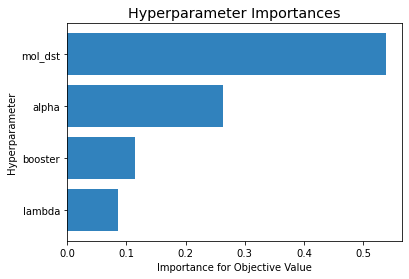

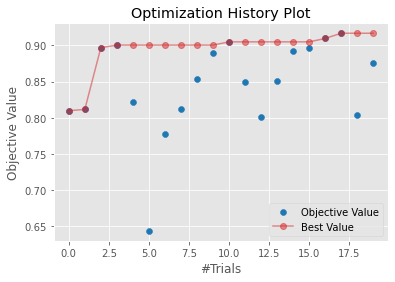

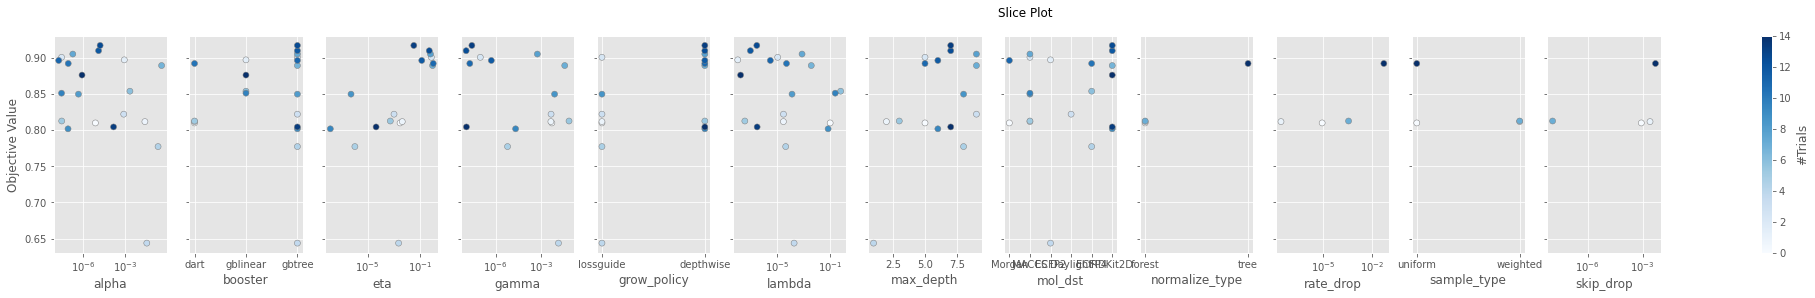

In [11]:
v1 = oviz.plot_param_importances(study)
v2 = oviz.plot_optimization_history(study)
v3 = oviz.plot_slice(study)

def fig_name(name):
    return(optuna_dir + "output/" + "{}.{}_{}.{}.{}_{}.pdf".format(my_time.hour, my_time.minute, my_time.month, my_time.day, my_time.year, name))

v1.figure.savefig(fig_name("HyperparameterImportance"))
v2.figure.savefig(fig_name("OptimizationHistory"))

Finally, I train a new model based on the best trial.

In [12]:
# train new model based on the best trial
best_xgb_model = xgb.Booster()
best_xgb_model.load_model(model_dir + "xgboost_model_{}.json".format(best_trial.number))

I visualize the best tree with the `matplotlib` library. This requires `pip install graphviz`, see [this tutorial](https://www.datacamp.com/community/tutorials/xgboost-in-python).

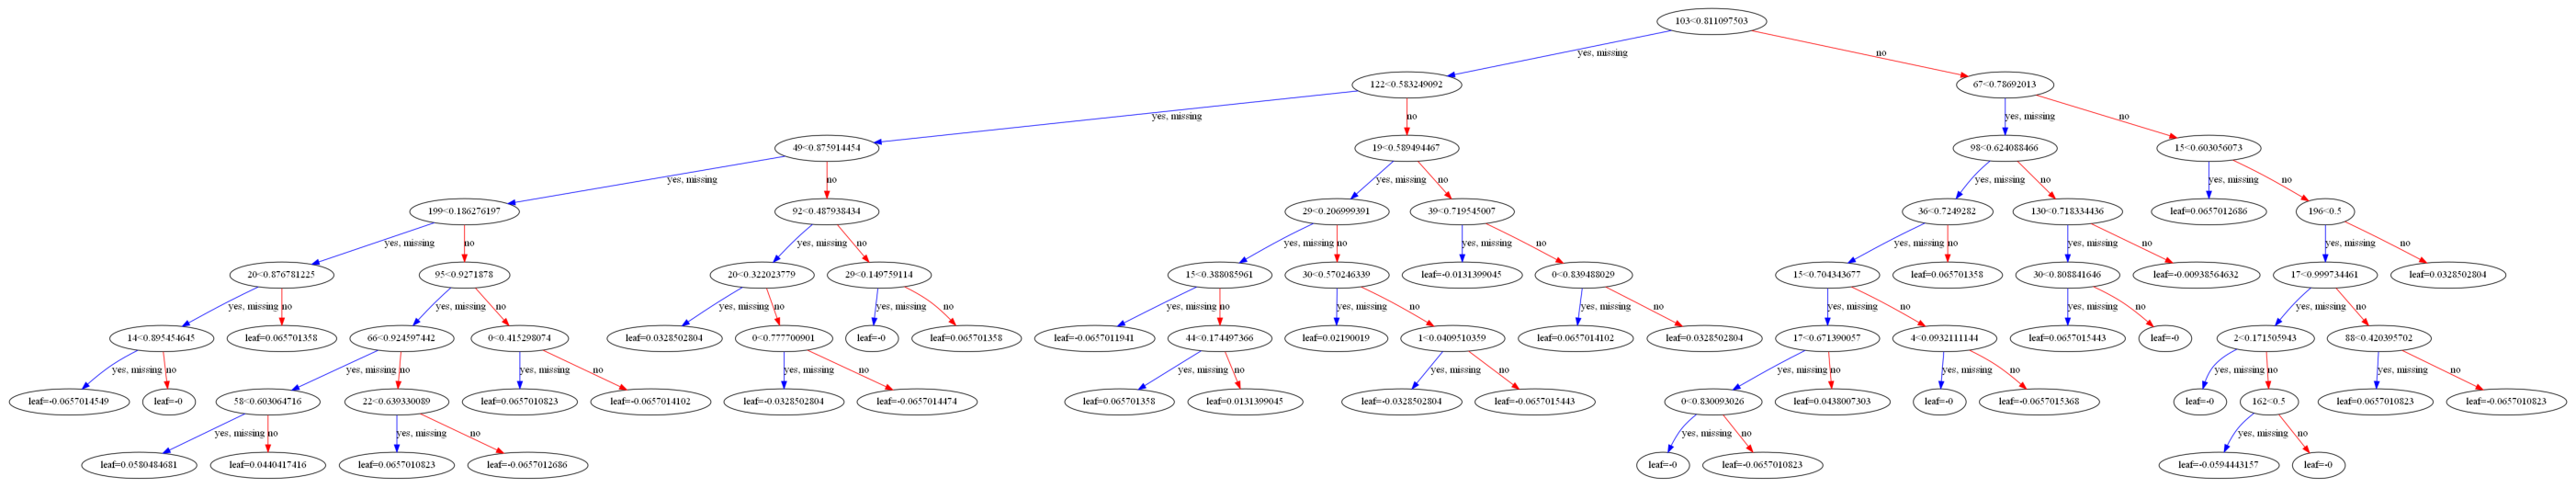

In [20]:
xgb.plot_tree(best_xgb_model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig(fig_name("BestXGBoostTree"), dpi = 900)

I also plot feature importance.

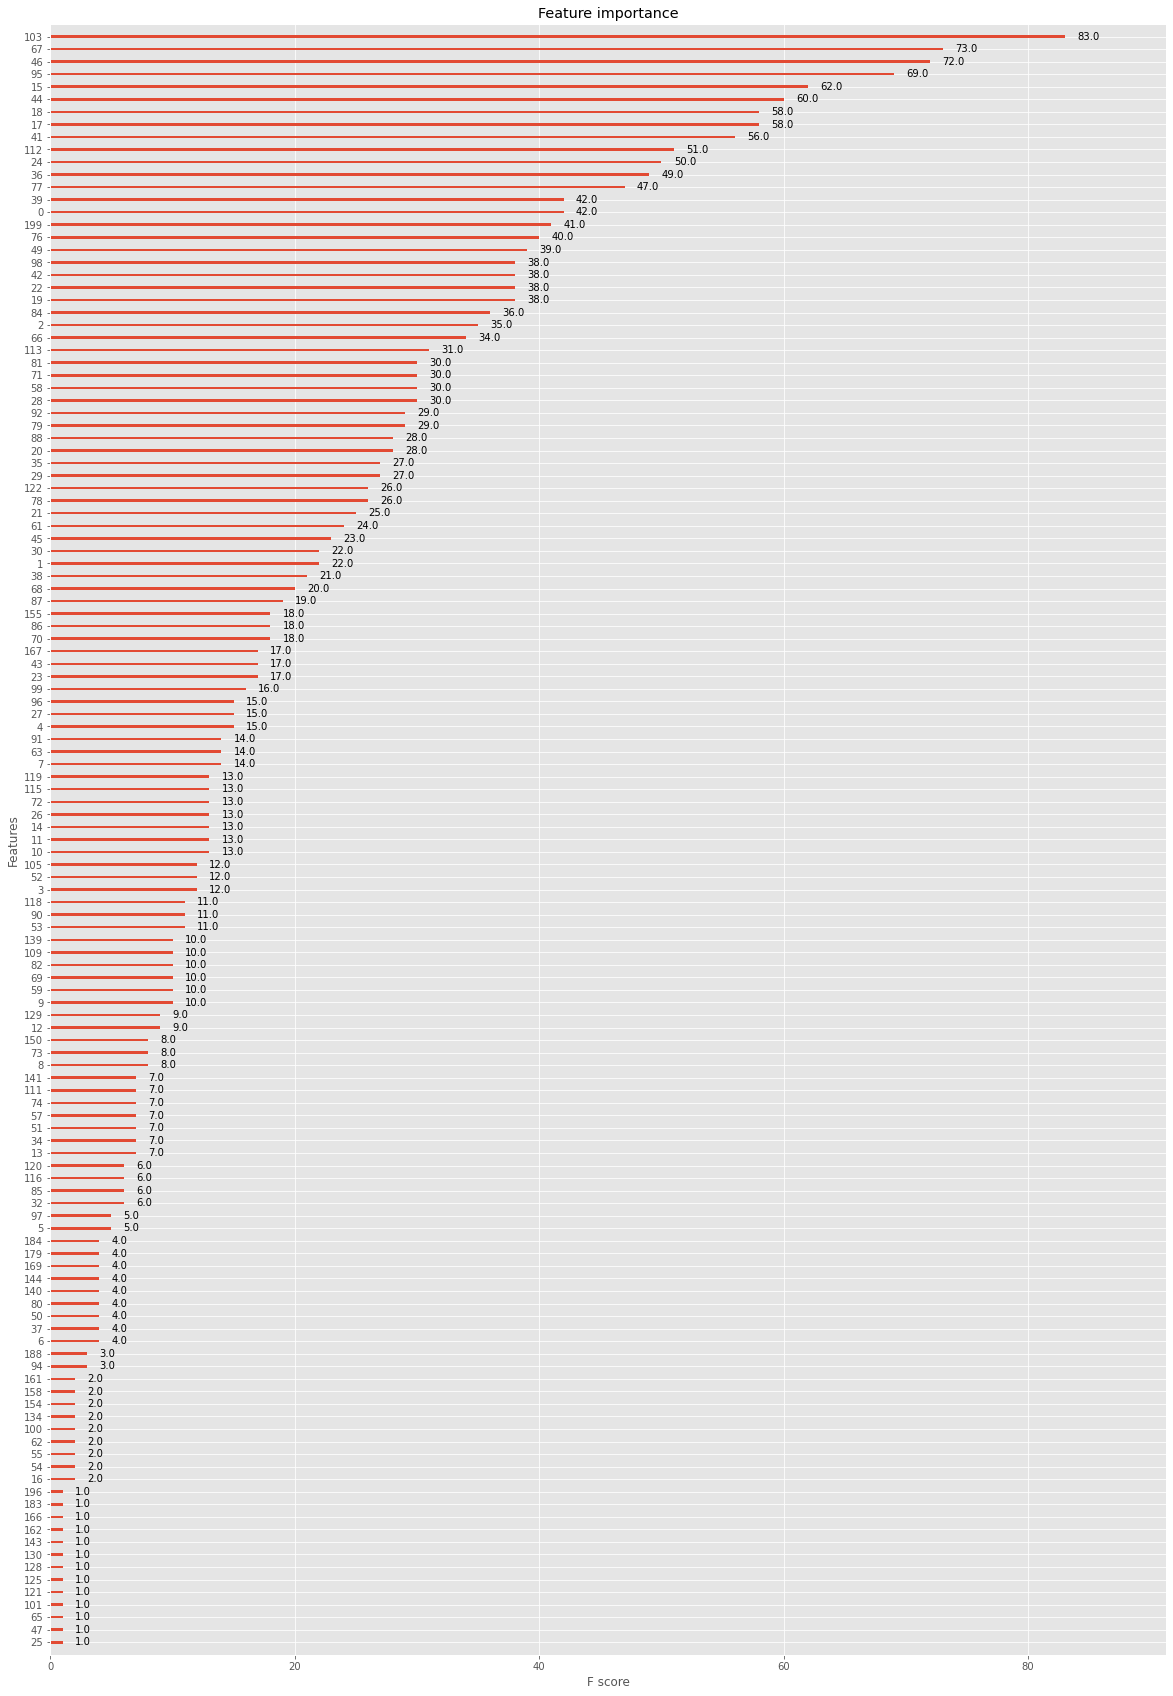

In [25]:
xgb.plot_importance(best_xgb_model)
plt.rcParams['figure.figsize'] = [10, 30]
plt.savefig(fig_name("FeatureImportance"), dpi = 900)

Now, I evaluate on the independent test set.

In [35]:
# convert fingerprint
test_converter = MolConvert(src = 'SMILES', dst = best_trial.params['mol_dst'])
test_features = pd.DataFrame([test_converter(x) for x in test['Drug']])
dtest = xgb.DMatrix(test_features, label = test['Y'])

Test set evaluation.

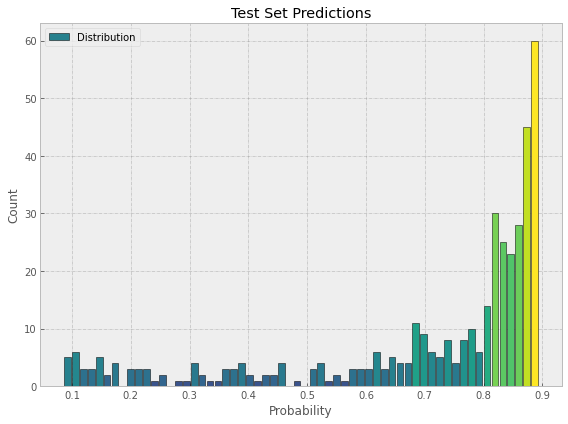

In [83]:
# evaluate on test set
y_pred_test = best_xgb_model.predict(dtest)

# set style
with plt.style.context('bmh'):

    # create figure
    fig, axs = plt.subplots(1, 1, figsize = (8, 6), tight_layout = True)

    # add grid lines
    axs.grid(b = True, color = 'grey', linestyle = '-.', linewidth = 0.5, alpha = 0.6)

    # create histogram
    max_value = np.max(y_pred_test)
    bin_width = 0.015
    nbins = np.ceil(max_value/bin_width)
    N, bins, patches = axs.hist(y_pred_test, bins = int(nbins), rwidth = 0.85, edgecolor = "black")

    # set color
    fracs = ((N**(1 / 3))/N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    # add labels
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.legend(['Distribution'])
    plt.title("Test Set Predictions")

# show plot
plt.savefig(fig_name("TestSetPredictions"), dpi = 900)

Finally, evaluate the results of the predictions.

In [32]:
# append predictions to test set object
predictions[name] = y_pred_test
predictions_list.append(predictions)

# evaluate predictions on test set
# print(group.evaluate_many(predictions_list))
group.evaluate(predictions_list[0])

{'bbb_martins': {'roc-auc': 0.87}}

Next, I plot the ROC curve on the independent test set.

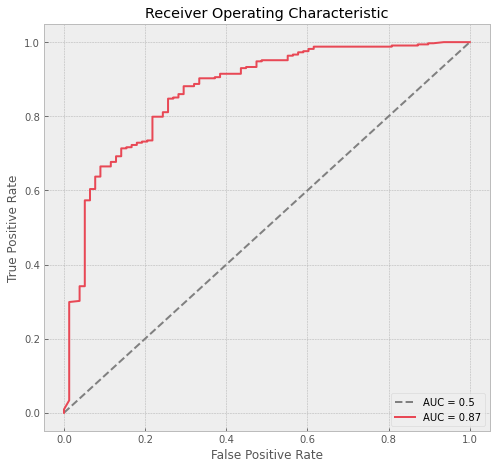

In [79]:
# get FPR and TPR
fpr, tpr, _ = metrics.roc_curve(test['Y'],  y_pred_test)
auc = metrics.roc_auc_score(test['Y'],  y_pred_test)

# create ROC curve
# see plt.style.available for available styles
with plt.style.context('bmh'):
    plt.figure(figsize = (8, 7.5))
    plt.plot([0, 1], [0, 1], label = "AUC = 0.5", color = "gray", linestyle = '--', linewidth = 2)
    plt.plot(fpr, tpr, label = "AUC = " + str(round(auc, 3)), color = "#E84855", linewidth = 2)
    plt.title("Receiver Operating Characteristic")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc = 4)

# save figure
plt.savefig(fig_name("TestSetROC"), dpi = 900)